In [1]:
import numpy as np
import uproot
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import Normalize
import scipy.stats as ss
from scipy.optimize import curve_fit
from scipy.stats import norm
from ntuple_lib import *
beautify_plots(plt)
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
import matplotlib as mpl
plt.rcParams["figure.figsize"] = (12, 8)

In [2]:
def computeLocalPUDensity(all_events_vertex_zs, delta_z):
    localPUdensity = []
    for vertex_zs in all_events_vertex_zs:
        localPUdensity.append((np.sum(np.abs(vertex_zs[0]-vertex_zs[1:]) < delta_z))/(2*delta_z))
    return localPUdensity
def computeAvgPUDensity(all_events_vertex_zs, mu=200, sigma_z=50):
    avgPUdensity = []
    for vertex_zs in all_events_vertex_zs:
        avgPUdensity.append(mu/(sigma_z*np.sqrt(2*np.pi)) * np.exp(-0.5*vertex_zs[0]**2/sigma_z**2))
    return avgPUdensity

In [3]:
# files = ['ntuples_condor/OutDir_{}/hist-Rel21sample.root'.format(i) for i in range(1, 10)]
files = ['../ntuples/ttbar/hist-Rel21sample.root']
track_t = np.array([], dtype='object')
track_z0 = np.array([], dtype='object')
track_z0_var = np.array([], dtype='object')
track_z = np.array([], dtype='object')
track_t30 = np.array([], dtype='object')
track_t90 = np.array([], dtype='object')
track_t180 = np.array([], dtype='object')

reco_vertex_track_idxs = np.array([], dtype='object')
reco_vertex_track_weights = np.array([], dtype='object')
truth_vertex_track_idxs = np.array([], dtype='object')

reco_vertex_sumPt2 = np.array([], dtype='object')

reco_vertex_z = np.array([], dtype='object')
truth_vertex_z = np.array([], dtype='object')
truth_vertex_t = np.array([], dtype='object')

for file in files:
    root_file = uproot.open(file)
    for key in root_file.keys():
        if key.startswith('EventTree'):
            tree = root_file[key]
            track_t = np.concatenate((track_t, tree['track_t'].array(library='np')))
            track_z0 = np.concatenate((track_z0, tree['track_z0'].array(library='np')))
            track_z0_var = np.concatenate((track_z0_var, tree['track_var_z0'].array(library='np')))
            track_z = np.concatenate((track_z, tree['track_z'].array(library='np')))
            track_t30 = np.concatenate((track_t30, tree['track_t30'].array(library='np')))
            track_t90 = np.concatenate((track_t90, tree['track_t90'].array(library='np')))
            track_t180 = np.concatenate((track_t180, tree['track_t180'].array(library='np')))
            
            reco_vertex_track_idxs = np.concatenate((reco_vertex_track_idxs, tree['recovertex_tracks_idx'].array(library='np')))
            reco_vertex_track_weights = np.concatenate((reco_vertex_track_weights, tree['recovertex_tracks_weight'].array(library='np')))
            truth_vertex_track_idxs = np.concatenate((truth_vertex_track_idxs, tree['truthvertex_tracks_idx'].array(library='np')))
            
            reco_vertex_sumPt2 = np.concatenate((reco_vertex_sumPt2, tree['recovertex_sumPt2'].array(library='np')))
            
            reco_vertex_z = np.concatenate((reco_vertex_z, tree['recovertex_z'].array(library='np')))
            truth_vertex_z = np.concatenate((truth_vertex_z, tree['truthvertex_z'].array(library='np')))
            truth_vertex_t = np.concatenate((truth_vertex_t, tree['truthvertex_t'].array(library='np')))

In [4]:
track_z_flat = np.concatenate(track_z)
track_z0_flat = np.concatenate(track_z0)
diff_track_z = track_z0_flat-track_z_flat

delta_track_z_recoHS = np.array([])
delta_track_z_truthHS = np.array([])
for idx in range(len(track_z)):
    reco_idx = reco_vertex_track_idxs[idx][0]
    truth_idx = truth_vertex_track_idxs[idx][0]
    delta_track_z_recoHS = np.concatenate((delta_track_z_recoHS, track_z[idx][reco_idx] - track_z0[idx][reco_idx]))
    delta_track_z_truthHS = np.concatenate((delta_track_z_truthHS, track_z[idx][truth_idx] - track_z0[idx][truth_idx]))

Text(0.5, 0, 'Reco track z0 - truth track z [mm]')

findfont: Font family ['Helvetica', 'Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Helvetica', 'Arial'] not found. Falling back to DejaVu Sans.


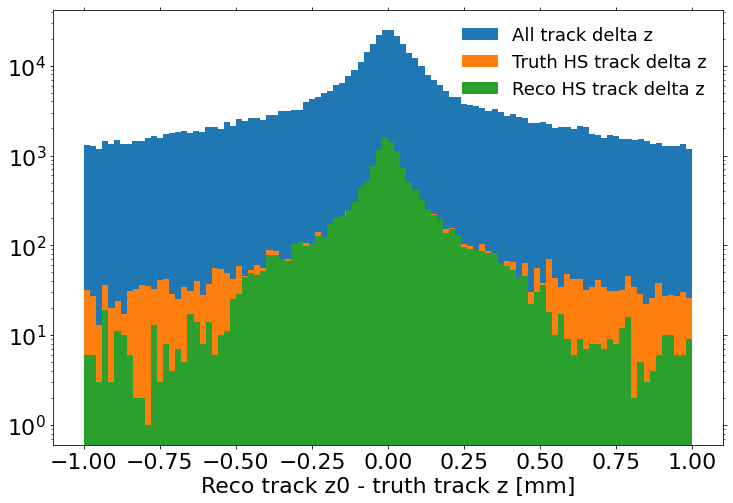

In [5]:
max_z = 1
_ = plt.hist(diff_track_z[np.abs(diff_track_z) < max_z], bins=100, label='All track delta z')
_ = plt.hist(delta_track_z_truthHS[np.abs(delta_track_z_truthHS) < max_z], bins=100, label='Truth HS track delta z')
_ = plt.hist(delta_track_z_recoHS[np.abs(delta_track_z_recoHS) < max_z], bins=100, label='Reco HS track delta z')
plt.yscale('log')
plt.legend(frameon=False)
plt.xlabel('Reco track z0 - truth track z [mm]')

In [ ]:
# cut >1 track pT
# plot vs track eta

In [6]:
## Find truth link via number of shared tracks
recoHS_to_truth_link_idx = []
truthHS_to_reco_link_idx = []
for event_idx in range(len(truth_vertex_t)):
    event_reco_to_truth_n_tracks = -1
    event_reco_to_truth_idx = -1
    reco_hs_track_idx = reco_vertex_track_idxs[event_idx][0]
    for i, truth_track_idxs in enumerate(truth_vertex_track_idxs[event_idx]):
        n = len(np.intersect1d(reco_hs_track_idx, truth_track_idxs))
        if n > event_reco_to_truth_n_tracks and i < 100:
            # print(event_idx, n)
            event_reco_to_truth_n_tracks = n
            event_reco_to_truth_idx = i
    
    event_truth_to_reco_n_tracks = -1
    event_truth_to_reco_idx = -1
    truth_hs_track_idx = truth_vertex_track_idxs[event_idx][0]
    for i, reco_track_idxs in enumerate(reco_vertex_track_idxs[event_idx]):
        n = len(np.intersect1d(truth_hs_track_idx, reco_track_idxs))
        if n > event_truth_to_reco_n_tracks and i < 100:
            # print(event_idx, n)
            event_truth_to_reco_n_tracks = n
            event_truth_to_reco_idx = i
    
    recoHS_to_truth_link_idx.append(event_reco_to_truth_idx)
    truthHS_to_reco_link_idx.append(event_truth_to_reco_idx)
recoHS_to_truth_link_idx = np.array(recoHS_to_truth_link_idx)
truthHS_to_reco_link_idx = np.array(truthHS_to_reco_link_idx)

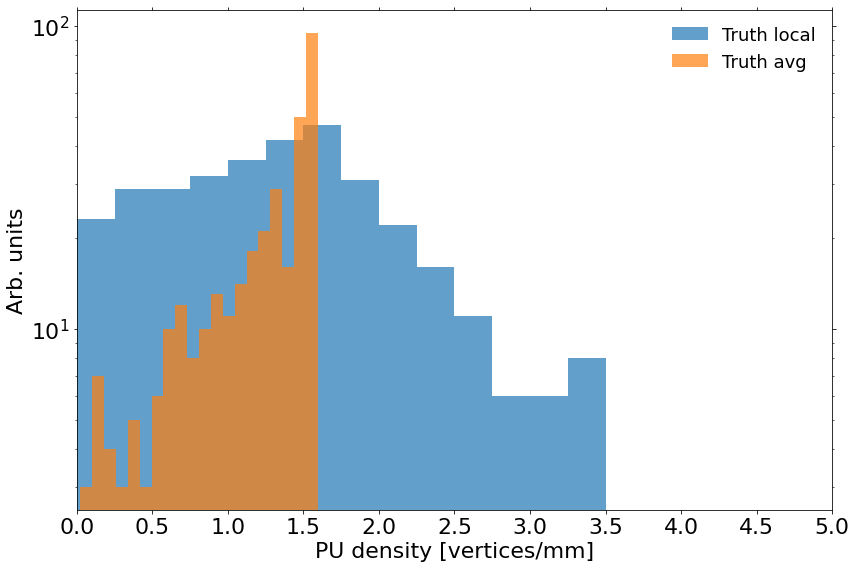

In [7]:
delta_z = 2
truth_localPU = computeLocalPUDensity(truth_vertex_z, delta_z)
reco_localPU = computeLocalPUDensity(reco_vertex_z,   delta_z)

truth_avgPU = computeAvgPUDensity(truth_vertex_z)
reco_avgPU = computeAvgPUDensity(reco_vertex_z)

binwidth = 1/(2*delta_z)

_, truth_bin_edges, _ = plt.hist(truth_localPU, bins=np.arange(np.min(truth_localPU), np.max(truth_localPU) + binwidth, binwidth), density=False, alpha=0.7, label='Truth local')
# _, reco_bin_edges, _  = plt.hist(reco_localPU,  bins=np.arange(np.min(reco_localPU), np.max(reco_localPU) + binwidth, binwidth), density=False, alpha=0.7, label='Reco local')

_, truth_avg_bin_edges, _ = plt.hist(truth_avgPU, bins=20, density=False, alpha=0.7, label='Truth avg')
# _, reco_avg_bin_edges, _  = plt.hist(reco_avgPU,  bins=np.arange(np.min(reco_localPU), np.max(reco_localPU) + binwidth, binwidth), density=False, alpha=0.7, label='Reco avg')

# plt.text(0.1, 1900, 'Local PU $\\Delta z = {}$ mm'.format(delta_z), fontsize=22)

plt.xlabel('PU density [vertices/mm]')
plt.ylabel('Arb. units')
plt.yscale('log')
plt.xticks(np.arange(0, 10, 0.5))
plt.xlim(0, 5)
plt.legend(frameon=False)
plt.tight_layout()

In [8]:
events_in_PU_bins = []
for bin in truth_bin_edges:
    events_in_PU_bins.append(np.argwhere(np.isclose(truth_localPU, bin)))

weighted_vs_fit_delta_z = []
weight_cut_vs_fit_delta_z = []

weighted_vs_truth_delta_z = []
weight_cut_vs_truth_delta_z = []

for event_idxs in events_in_PU_bins:
    bin_weighted_vs_fit_delta_z = []
    bin_weight_cut_vs_fit_delta_z = []
    bin_weighted_vs_truth_delta_z = []
    bin_weight_cut_vs_truth_delta_z = []
    
    for idx in event_idxs:
        idx = idx[0]
        reco_idx = 0
        weighted_reco_z = np.average(track_z0[idx][reco_vertex_track_idxs[idx][reco_idx]], weights=np.array(reco_vertex_track_weights[idx][reco_idx]))
        bin_weighted_vs_fit_delta_z.append(weighted_reco_z - reco_vertex_z[idx][reco_idx])
        weight_cut_idx = np.array(reco_vertex_track_weights[idx][reco_idx]) > 0.9
        weight_cut_reco_z = np.average(track_z0[idx][reco_vertex_track_idxs[idx][reco_idx]][weight_cut_idx], weights=np.array(reco_vertex_track_weights[idx][reco_idx][weight_cut_idx]))
        bin_weight_cut_vs_fit_delta_z.append(weight_cut_reco_z - reco_vertex_z[idx][reco_idx])
        
        reco_idx = truthHS_to_reco_link_idx[idx]
        weighted_reco_z = np.average(track_z0[idx][reco_vertex_track_idxs[idx][reco_idx]], weights=np.array(reco_vertex_track_weights[idx][reco_idx]))
        bin_weighted_vs_truth_delta_z.append(weighted_reco_z - truth_vertex_z[idx][0])
        weight_cut_idx = np.array(reco_vertex_track_weights[idx][reco_idx]) > 0.9
        weight_cut_reco_z = np.average(track_z0[idx][reco_vertex_track_idxs[idx][reco_idx]][weight_cut_idx], weights=np.array(reco_vertex_track_weights[idx][reco_idx][weight_cut_idx]))
        bin_weight_cut_vs_truth_delta_z.append(weight_cut_reco_z - truth_vertex_z[idx][0])
        
        
    weighted_vs_fit_delta_z.append(bin_weighted_vs_fit_delta_z)
    weight_cut_vs_fit_delta_z.append(bin_weight_cut_vs_fit_delta_z)
    weighted_vs_truth_delta_z.append(bin_weighted_vs_truth_delta_z)
    weight_cut_vs_truth_delta_z.append(bin_weight_cut_vs_truth_delta_z)

In [21]:
np.std(np.concatenate(weight_cut_vs_fit_delta_z))

0.05944757

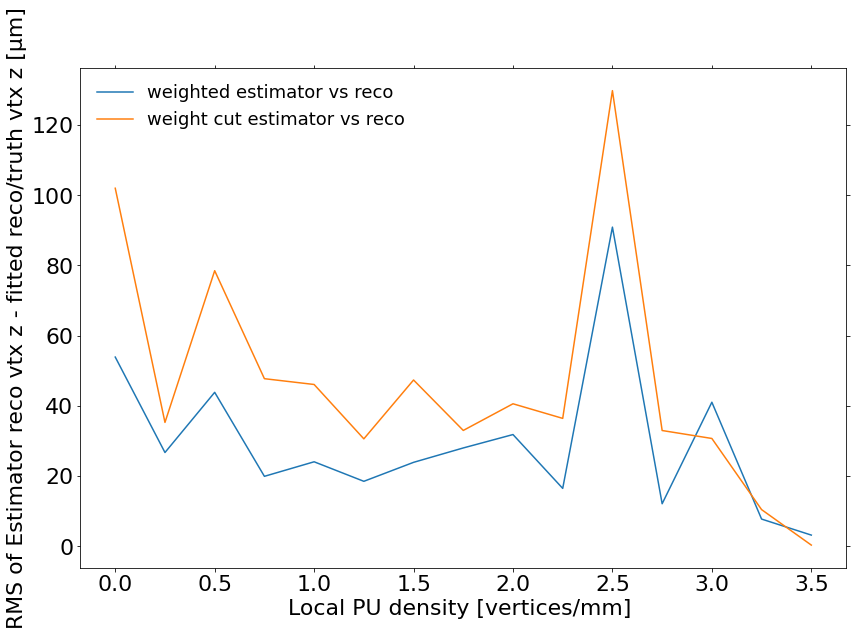

In [9]:
plt.plot(truth_bin_edges, 1e3*np.array([np.std(delta_z) for delta_z in weighted_vs_fit_delta_z]), label='weighted estimator vs reco')
plt.plot(truth_bin_edges, 1e3*np.array([np.std(delta_z) for delta_z in weight_cut_vs_fit_delta_z]), label='weight cut estimator vs reco')
# plt.plot(truth_bin_edges, 1e3*np.array([np.std(delta_z) for delta_z in weighted_vs_truth_delta_z]), label='weighted estimator vs truth')
# plt.plot(truth_bin_edges, 1e3*np.array([np.std(delta_z) for delta_z in weight_cut_vs_truth_delta_z]), label='weight cut estimator vs truth')

plt.xlabel('Local PU density [vertices/mm] ')
plt.ylabel('RMS of Estimator reco vtx z - fitted reco/truth vtx z [µm]')
plt.legend(frameon=False, loc='upper left')
plt.tight_layout()

In [ ]:
events_in_PU_bins = []
for bin in truth_bin_edges:
    events_in_PU_bins.append(np.argwhere(np.isclose(truth_localPU, bin)))
    
closest_truth_localPU_bins_delta_zs = []
closest_truth_localPU_bins_delta_z_rms_all = []
closest_truth_localPU_bins_vtx_z_res = []

closest_truth_localPU_bins_delta_z_weighted_rms_all = []
closest_truth_localPU_bins_vtx_z_weighted_res = []

w_cut = 0.9

closest_truth_localPU_bins_w_cut_delta_zs = []
closest_truth_localPU_bins_w_cut_delta_z_rms_all = []
closest_truth_localPU_bins_w_cut_vtx_z_res = []

for event_idxs in events_in_PU_bins:
    
    bin_closest_truth_delta_zs = np.array([])
    bin_closest_truth_delta_z_rms = []
    bin_closest_truth_delta_z_weighted_rms = []
    bin_closest_truth_n_tracks = []
    
    bin_closest_truth_w_cut_delta_zs = np.array([])
    bin_closest_truth_w_cut_delta_z_rms = []
    bin_closest_truth_w_cut_n_tracks = []
    
    for event_idx in event_idxs:
        event_idx = event_idx[0]
        reco_track_weights = reco_vertex_track_weights[event_idx][0]
        
        reco_vtx_z = reco_vertex_z[event_idx][0]
        closest_truth_z = truth_vertex_z[event_idx][np.argmin(np.abs(truth_vertex_z[event_idx] - reco_vtx_z))]
        
        delta_zs = track_z0[event_idx][reco_vertex_track_idxs[event_idx][0]] - closest_truth_z

        bin_closest_truth_delta_zs = np.concatenate((bin_closest_truth_delta_zs, delta_zs))
        bin_closest_truth_delta_z_rms.append(np.sqrt(np.mean(delta_zs**2)))
        bin_closest_truth_delta_z_weighted_rms.append(np.sqrt(np.average(delta_zs**2, weights=reco_track_weights)))
        bin_closest_truth_n_tracks.append(len(delta_zs))
        
        cut_idx = np.array(reco_track_weights) > w_cut
        bin_closest_truth_w_cut_delta_zs = np.concatenate((bin_closest_truth_delta_zs, delta_zs[cut_idx]))
        bin_closest_truth_w_cut_delta_z_rms.append(np.sqrt(np.average(delta_zs[cut_idx]**2)))
        bin_closest_truth_w_cut_n_tracks.append(len(delta_zs[cut_idx]))
        
    closest_truth_localPU_bins_delta_zs.append(bin_closest_truth_delta_zs)
    closest_truth_localPU_bins_delta_z_rms_all.append(bin_closest_truth_delta_z_rms)
    closest_truth_localPU_bins_vtx_z_res.append(np.mean(bin_closest_truth_delta_z_rms / np.sqrt(np.array(bin_closest_truth_n_tracks))))
    closest_truth_localPU_bins_delta_z_weighted_rms_all.append(bin_closest_truth_delta_z_weighted_rms)
    closest_truth_localPU_bins_vtx_z_weighted_res.append(np.mean(bin_closest_truth_delta_z_weighted_rms / np.sqrt(np.array(bin_closest_truth_n_tracks))))
    
    closest_truth_localPU_bins_w_cut_delta_zs.append(bin_closest_truth_w_cut_delta_zs)
    closest_truth_localPU_bins_w_cut_delta_z_rms_all.append(bin_closest_truth_w_cut_delta_z_rms)
    closest_truth_localPU_bins_w_cut_vtx_z_res.append(np.nanmean(bin_closest_truth_w_cut_delta_z_rms / np.sqrt(np.array(bin_closest_truth_w_cut_n_tracks))))

In [10]:
def vtx_z_info(events_in_bins, truth_vtx_idx_in_bins, all_truth_vtx_z, reco_vtx_idx_in_bins, all_reco_track_idxs, all_reco_track_weights, all_track_z0, sigma_cut, weight_cut):
    track_delta_z = []
    track_delta_z_rms = []
    
    track_weight_cut_delta_z = []
    track_weight_cut_delta_z_rms = []
    
    track_sigma_cut_delta_z = []
    track_sigma_cut_delta_z_rms = []
    
    track_vtx_z_res = []
    track_vtx_z_res_weight_cut = []
    track_vtx_z_res_sigma_cut = []
    
    vtx_delta_z = []
    vtx_weighted_delta_z = []
    vtx_weight_cut_delta_z = []
    
    vtx_z_res = []
    vtx_weighted_z_res = []
    vtx_weight_cut_z_res = []
    vtx_weight_cut_weighted_z_res = []
    vtx_sigma_cut_weighted_z_res = []
    
    vtx_z_res_tracks_sigma_cut = []
    vtx_weighted_z_res_tracks_sigma_cut = []

    avg_n_tracks = []
    avg_n_tracks_weight_cut = []
    avg_n_tracks_sigma_cut = []

    for event_idxs, truth_vtx_idxs, reco_vtx_idxs in zip(events_in_bins, truth_vtx_idx_in_bins, reco_vtx_idx_in_bins):
        bin_track_delta_z = np.array([])
        bin_track_delta_z_rms = []
        
        bin_vtx_delta_z = []
        bin_vtx_weighted_delta_z = []
        
        bin_track_weight_cut_delta_z = np.array([])
        bin_track_weight_cut_delta_z_rms = []
        
        bin_vtx_weight_cut_delta_z = []
        bin_vtx_weight_cut_weighted_delta_z = []
        
        bin_reco_n_tracks = []
        bin_reco_n_tracks_weight_cut = []
        for idx, truth_idx, reco_idx in zip(event_idxs, truth_vtx_idxs, reco_vtx_idxs):
            idx = idx[0]
            reco_track_z = all_track_z0[idx][all_reco_track_idxs[idx][reco_idx]]
            reco_track_weights = all_reco_track_weights[idx][reco_idx]
            bin_reco_n_tracks.append(len(reco_track_z))
            
            truth_z = all_truth_vtx_z[idx][truth_idx]
            event_track_delta_z = reco_track_z - truth_z
            
            bin_track_delta_z = np.concatenate((bin_track_delta_z, event_track_delta_z))
            bin_track_delta_z_rms.append(np.sqrt(np.mean(event_track_delta_z**2)))
            
            reco_vtx_z = np.mean(reco_track_z)
            reco_vtx_weighted_z = np.average(reco_track_z, weights=reco_track_weights)
            
            bin_vtx_delta_z.append(reco_vtx_z - truth_z)
            bin_vtx_weighted_delta_z.append(reco_vtx_weighted_z - truth_z)
            
            # Weight cut
            weight_cut_idx = np.array(reco_track_weights) > weight_cut
            weight_cut_track_z = reco_track_z[weight_cut_idx]
            bin_reco_n_tracks_weight_cut.append(len(weight_cut_track_z))
            
            weight_cut_event_delta_z = weight_cut_track_z - truth_z
        
            bin_track_weight_cut_delta_z = np.concatenate((bin_track_weight_cut_delta_z, weight_cut_event_delta_z))
            bin_track_weight_cut_delta_z_rms.append(np.sqrt(np.mean(weight_cut_event_delta_z**2)))
            
            weight_cut_vtx_z = np.mean(weight_cut_track_z)
            weight_cut_vtx_weighted_z = np.average(weight_cut_track_z, weights = reco_track_weights[weight_cut_idx])
            
            bin_vtx_weight_cut_delta_z.append(weight_cut_vtx_z - truth_z)
            bin_vtx_weight_cut_weighted_delta_z.append(weight_cut_vtx_weighted_z - truth_z)
        
        avg_n_tracks.append(np.mean(bin_reco_n_tracks))
        avg_n_tracks_weight_cut.append(np.mean(bin_reco_n_tracks_weight_cut))
        
        track_delta_z.append(bin_track_delta_z)
        track_delta_z_rms.append(bin_track_delta_z_rms)
        track_weight_cut_delta_z.append(bin_track_weight_cut_delta_z)
        track_weight_cut_delta_z_rms.append(bin_track_weight_cut_delta_z_rms)
        track_vtx_z_res.append(np.mean(bin_track_delta_z_rms / np.sqrt(np.array(bin_reco_n_tracks))))
        track_vtx_z_res_weight_cut.append(np.mean(bin_track_weight_cut_delta_z_rms / np.sqrt(np.array(bin_reco_n_tracks_weight_cut))))
        
        
        vtx_delta_z.append(bin_vtx_delta_z)
        vtx_weighted_delta_z.append(bin_vtx_weighted_delta_z)
        vtx_weight_cut_delta_z.append(bin_vtx_weight_cut_delta_z)
        
        vtx_z_res.append(np.sqrt(np.mean(np.array(bin_vtx_delta_z)**2)))
        vtx_weighted_z_res.append(np.sqrt(np.mean(np.array(bin_vtx_weighted_delta_z)**2)))
        vtx_weight_cut_z_res.append(np.sqrt(np.mean(np.array(bin_vtx_weight_cut_delta_z)**2)))
        vtx_weight_cut_weighted_z_res.append(np.sqrt(np.mean(np.array(bin_vtx_weight_cut_weighted_delta_z)**2)))
        
        bin_vtx_weighted_delta_z_sigma = np.std(bin_vtx_weighted_delta_z, ddof=1)
        bin_vtx_delta_z_sigma_cut_idxs = np.abs(bin_vtx_weighted_delta_z - np.mean(bin_vtx_weighted_delta_z)) < sigma_cut*bin_vtx_weighted_delta_z_sigma
        vtx_sigma_cut_weighted_z_res.append(np.sqrt(np.mean(np.array(bin_vtx_weight_cut_weighted_delta_z)[bin_vtx_delta_z_sigma_cut_idxs]**2)))
        
        
        ## Sigma cutting on tracks both for track based estimate on vtx z res and estimator of vtx z 
        bin_track_sigma = np.std(bin_track_delta_z)
        bin_track_sigma_cut_delta_z = []
        bin_track_sigma_cut_delta_z_rms = []
        bin_reco_n_tracks_sigma_cut = []
        
        bin_vtx_delta_z_tracks_sigma_cut = []
        bin_vtx_weighted_delta_z_tracks_sigma_cut = []
        
        for idx, truth_idx, reco_idx in zip(event_idxs, truth_vtx_idxs, reco_vtx_idxs):
            idx = idx[0]
            reco_track_z = all_track_z0[idx][all_reco_track_idxs[idx][reco_idx]]
            reco_track_weights = all_reco_track_weights[idx][reco_idx]
            
            truth_z = all_truth_vtx_z[idx][truth_idx]
            event_track_delta_z = reco_track_z - truth_z
            
            track_sigma_cut_idx = np.abs(event_track_delta_z - np.mean(event_track_delta_z)) < sigma_cut*bin_track_sigma
            event_track_delta_z_sigma_cut = event_track_delta_z[track_sigma_cut_idx]
            
            bin_track_sigma_cut_delta_z.append(event_track_delta_z)
            bin_track_sigma_cut_delta_z_rms.append(np.sqrt(np.mean(event_track_delta_z**2)))
            bin_reco_n_tracks_sigma_cut.append(len(event_track_delta_z_sigma_cut))
            
            reco_vtx_z_sigma_cut_tracks = np.mean(reco_track_z[track_sigma_cut_idx])
            reco_vtx_weighted_z_sigma_cut_tracks = np.average(reco_track_z[track_sigma_cut_idx], weights=reco_track_weights[track_sigma_cut_idx])
            
            bin_vtx_delta_z_tracks_sigma_cut.append(reco_vtx_z_sigma_cut_tracks - truth_z)
            bin_vtx_weighted_delta_z_tracks_sigma_cut.append(reco_vtx_weighted_z_sigma_cut_tracks - truth_z)
        
        track_sigma_cut_delta_z.append(bin_track_sigma_cut_delta_z)
        track_sigma_cut_delta_z_rms.append(bin_track_sigma_cut_delta_z_rms)
        track_vtx_z_res_sigma_cut.append(np.mean(bin_track_sigma_cut_delta_z_rms / np.sqrt(np.array(bin_reco_n_tracks_sigma_cut))))
        vtx_z_res_tracks_sigma_cut.append(np.sqrt(np.mean(np.array(bin_vtx_delta_z_tracks_sigma_cut)**2)))
        vtx_weighted_z_res_tracks_sigma_cut.append(np.sqrt(np.mean(np.array(bin_vtx_weighted_delta_z_tracks_sigma_cut)**2)))
            
    return  avg_n_tracks, \
            track_delta_z, \
            track_delta_z_rms, \
            track_weight_cut_delta_z, \
            track_weight_cut_delta_z_rms, \
            track_sigma_cut_delta_z, \
            track_sigma_cut_delta_z_rms, \
            track_vtx_z_res, \
            track_vtx_z_res_weight_cut, \
            track_vtx_z_res_sigma_cut, \
            vtx_delta_z, \
            vtx_weighted_delta_z, \
            vtx_weight_cut_delta_z, \
            vtx_z_res, \
            vtx_weighted_z_res, \
            vtx_weight_cut_z_res, \
            vtx_weight_cut_weighted_z_res, \
            vtx_sigma_cut_weighted_z_res, \
            vtx_z_res_tracks_sigma_cut, \
            vtx_weighted_z_res_tracks_sigma_cut
            
            
def closest_truth_vtx_z_info(events_in_PU_bins, all_truth_vtx_z, all_reco_track_idxs, all_reco_track_weights, all_reco_vtx_z, all_track_z0, sigma_cut, weight_cut):
    reco_vtx_idx_in_PU_bins = [[0 for idx in event_idx] for event_idx in events_in_PU_bins]
    truth_vtx_idx_in_PU_bins = [[np.argmin(np.abs(truth_vertex_z[idx[0]] - reco_vertex_z[idx[0]][0])) for idx in event_idx] for event_idx in events_in_PU_bins]
    return vtx_z_info(events_in_PU_bins, truth_vtx_idx_in_PU_bins, all_truth_vtx_z, reco_vtx_idx_in_PU_bins, all_reco_track_idxs, all_reco_track_weights, all_track_z0, sigma_cut, weight_cut)

def truth_to_reco_link_vtx_z_info(events_in_PU_bins, all_truthHS_to_reco_idx, all_truth_vtx_z, all_reco_track_idxs, all_reco_track_weights, all_track_z0, sigma_cut, weight_cut):
    truth_vtx_idx_in_PU_bins = [[0 for idx in event_idx] for event_idx in events_in_PU_bins]
    reco_vtx_idx_in_PU_bins = [[all_truthHS_to_reco_idx[idx[0]] for idx in event_idx] for event_idx in events_in_PU_bins]
    
    return vtx_z_info(events_in_PU_bins, truth_vtx_idx_in_PU_bins, all_truth_vtx_z, reco_vtx_idx_in_PU_bins, all_reco_track_idxs, all_reco_track_weights, all_track_z0, sigma_cut, weight_cut)
    

## TODO: write function to load root files into ram when needed instead of all at once 
    


In [11]:
events_in_PU_bins = []
for bin in truth_bin_edges:
    events_in_PU_bins.append(np.argwhere(np.isclose(truth_localPU, bin)))

ct_avg_n_tracks, \
ct_track_delta_z, \
ct_track_delta_z_rms, \
ct_track_weight_cut_delta_z, \
ct_track_weight_cut_delta_z_rms, \
ct_track_sigma_cut_delta_z, \
ct_track_sigma_cut_delta_z_rms, \
ct_track_vtx_z_res, \
ct_track_vtx_z_res_weight_cut, \
ct_track_vtx_z_res_sigma_cut, \
ct_vtx_delta_z, \
ct_vtx_weighted_delta_z, \
ct_vtx_weight_cut_delta_z, \
ct_vtx_z_res, \
ct_vtx_weighted_z_res, \
ct_vtx_weight_cut_z_res, \
ct_vtx_weight_cut_weighted_z_res, \
ct_vtx_sigma_cut_weighted_z_res, \
ct_vtx_z_res_tracks_sigma_cut, \
ct_vtx_weighted_z_res_tracks_sigma_cut = closest_truth_vtx_z_info(events_in_PU_bins, truth_vertex_z, reco_vertex_track_idxs, reco_vertex_track_weights, reco_vertex_z, track_z0, 2, 0.9)

link_avg_n_tracks, \
link_track_delta_z, \
link_track_delta_z_rms, \
link_track_weight_cut_delta_z, \
link_track_weight_cut_delta_z_rms, \
link_track_sigma_cut_delta_z, \
link_track_sigma_cut_delta_z_rms, \
link_track_vtx_z_res, \
link_track_vtx_z_res_weight_cut, \
link_track_vtx_z_res_sigma_cut, \
link_vtx_delta_z, \
link_vtx_weighted_delta_z, \
link_vtx_weight_cut_delta_z, \
link_vtx_z_res, \
link_vtx_weighted_z_res, \
link_vtx_weight_cut_z_res, \
link_vtx_weight_cut_weighted_z_res, \
link_vtx_sigma_cut_weighted_z_res, \
link_vtx_z_res_tracks_sigma_cut, \
link_vtx_weighted_z_res_tracks_sigma_cut = truth_to_reco_link_vtx_z_info(events_in_PU_bins, truthHS_to_reco_link_idx, truth_vertex_z, reco_vertex_track_idxs, reco_vertex_track_weights, track_z0, 2, 0.9)

Text(0.5, 0, 'Reco vtx track z - nearest truth vtx z [mm] ')

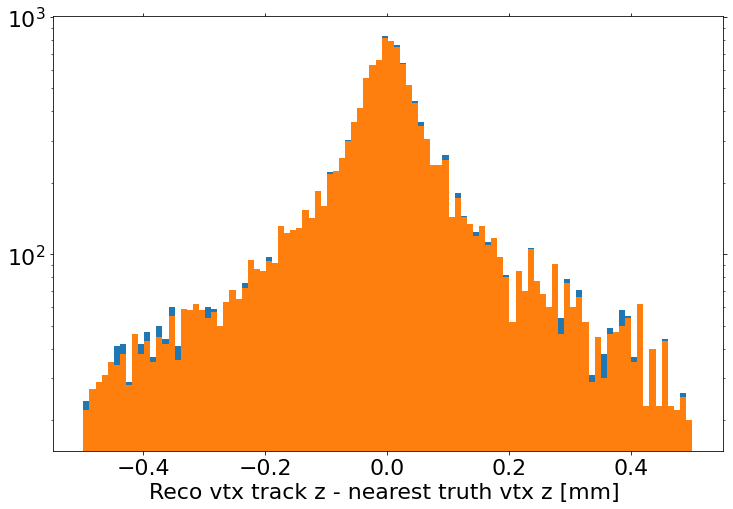

In [12]:
ct_track_delta_z_flat = np.concatenate(ct_track_delta_z)
_  = plt.hist(ct_track_delta_z_flat[np.abs(ct_track_delta_z_flat) < 0.5], bins=100)

link_track_delta_z_flat = np.concatenate(link_track_delta_z)
_  = plt.hist(link_track_delta_z_flat[np.abs(link_track_delta_z_flat) < 0.5], bins=100)

plt.yscale('log')
plt.xlabel('Reco vtx track z - nearest truth vtx z [mm] ')

In [ ]:
# fit core of gaussian
# plot sigma and rms
# see delta z w/o cut

# vertex z from avg track z w and w/o cut  

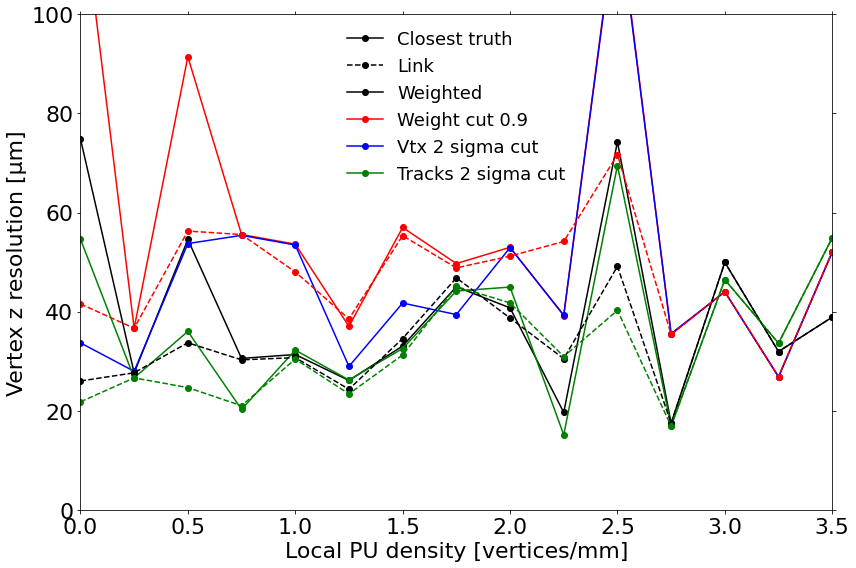

In [13]:
plt.plot([], [], 'ko-', label='Closest truth')
plt.plot([], [], 'ko--', label='Link')
plt.plot(truth_bin_edges, 1e3*np.array(ct_vtx_weighted_z_res), 'ko-', label='Weighted')
plt.plot(truth_bin_edges, 1e3*np.array(ct_vtx_weight_cut_z_res), 'ro-', label='Weight cut {}'.format(0.9))
plt.plot(truth_bin_edges, 1e3*np.array(ct_vtx_sigma_cut_weighted_z_res), 'bo-', label='Vtx {} sigma cut'.format(2))
plt.plot(truth_bin_edges, 1e3*np.array(ct_vtx_weighted_z_res_tracks_sigma_cut), 'go-', label='Tracks {} sigma cut'.format(2))

plt.plot(truth_bin_edges, 1e3*np.array(link_vtx_weighted_z_res), 'ko--')
plt.plot(truth_bin_edges, 1e3*np.array(link_vtx_weight_cut_z_res), 'ro--')
plt.plot(truth_bin_edges, 1e3*np.array(link_vtx_weighted_z_res_tracks_sigma_cut), 'go--')



plt.xlim(0, 3.5)
plt.ylim(0, 100)

plt.xlabel('Local PU density [vertices/mm]')
plt.ylabel('Vertex z resolution [µm]')
plt.legend(frameon=False)
plt.tight_layout()

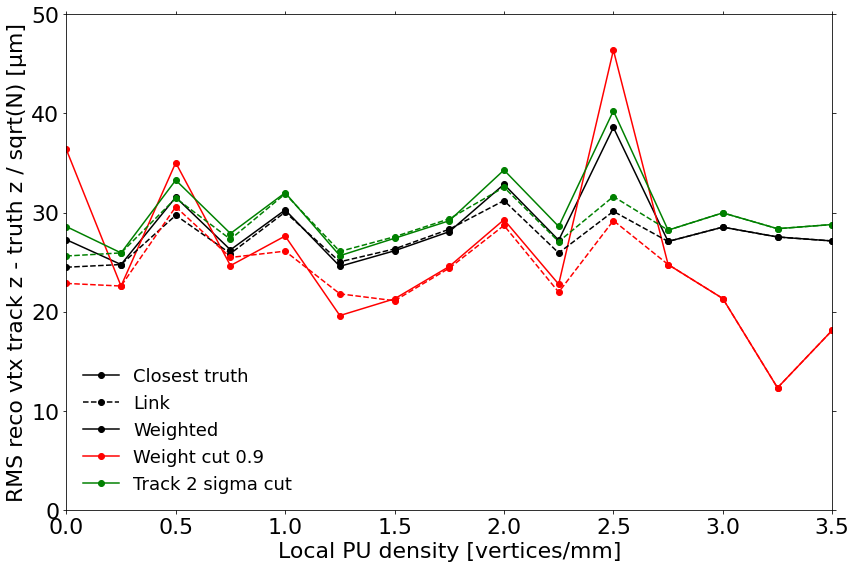

In [14]:
plt.plot([], [], 'ko-', label='Closest truth')
plt.plot([], [], 'ko--', label='Link')
plt.plot(truth_bin_edges, 1e3*np.array(ct_track_vtx_z_res), 'ko-', label='Weighted')
plt.plot(truth_bin_edges, 1e3*np.array(ct_track_vtx_z_res_weight_cut), 'ro-', label='Weight cut {}'.format(0.9))
plt.plot(truth_bin_edges, 1e3*np.array(ct_track_vtx_z_res_sigma_cut), 'go-', label='Track {} sigma cut'.format(2))

plt.plot(truth_bin_edges, 1e3*np.array(link_track_vtx_z_res), 'ko--')
plt.plot(truth_bin_edges, 1e3*np.array(link_track_vtx_z_res_weight_cut), 'ro--')
plt.plot(truth_bin_edges, 1e3*np.array(link_track_vtx_z_res_sigma_cut), 'go--')


plt.xlim(0, 3.5)
plt.ylim(0, 50)

plt.xlabel('Local PU density [vertices/mm]')
plt.ylabel('RMS reco vtx track z - truth z / sqrt(N) [µm]')
plt.legend(frameon=False)
plt.tight_layout()

In [15]:
plt.plot(truth_bin_edges, 1e3*np.array(closest_truth_localPU_bins_vtx_z_weighted_res), 'ko-', label='Unweighted')
# plt.plot(truth_bin_edges, 1e3*np.array(closest_truth_localPU_bins_vtx_z_res), 'bo-', label='Weighted avg')
plt.plot(truth_bin_edges, 1e3*np.array(closest_truth_localPU_bins_w_cut_vtx_z_res), 'ro-', label='Weight cut {}'.format(w_cut))


plt.xlim(0, 3.5)
# plt.ylim(0, 50)

plt.xlabel('Local PU density [vertices/mm]')
plt.ylabel('RMS reco vtx track z - truth z / sqrt(N) [µm]')
plt.legend(frameon=False)

NameError: name 'closest_truth_localPU_bins_vtx_z_weighted_res' is not defined

In [ ]:
# resolution vs distance to the closest truth vertex
# split into different eta regions

In [205]:
track_z0_var_recoHS = np.array([])
track_z0_var_truthHS = np.array([])
for idx in range(len(reco_vertex_track_idxs)):
    track_z0_var_recoHS = np.concatenate((track_z0_var_recoHS, track_z0_var[idx][reco_vertex_track_idxs[idx][0]]))
    track_z0_var_truthHS = np.concatenate((track_z0_var_truthHS, track_z0_var[idx][truth_vertex_track_idxs[idx][0]]))

Text(0.5, 0, 'track sigma_z0 [mm]')

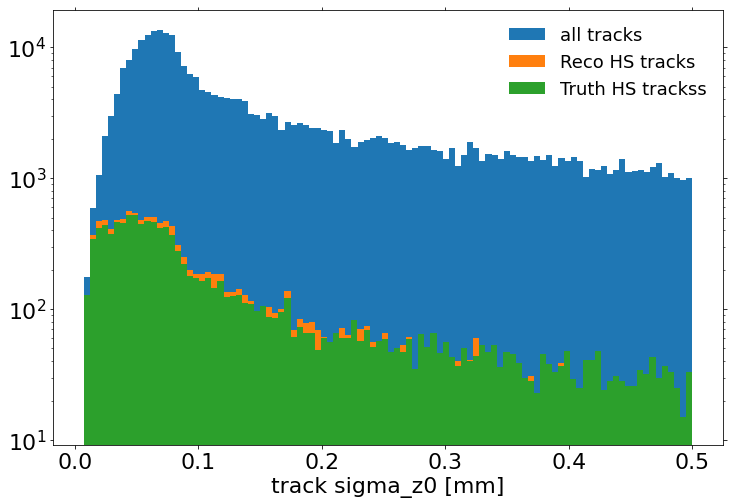

In [210]:
max_sigma = 0.5**2
_ = plt.hist(np.concatenate(track_z0_var)[np.concatenate(track_z0_var) < max_sigma]**0.5, bins=100, label='all tracks')
_ = plt.hist(track_z0_var_recoHS[track_z0_var_recoHS < max_sigma]**0.5, bins=100, label='Reco HS tracks')
_ = plt.hist(track_z0_var_truthHS[track_z0_var_truthHS < max_sigma]**0.5, bins=100, label='Truth HS trackss')
plt.yscale('log')
plt.legend(frameon=False)
plt.xlabel('track sigma_z0 [mm]')